In [194]:
from rf_classifier.models import CNNClassifier
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from rf_classifier.transforms import RandomAffine, ColorRescale, RandomColorRescale
from torch.optim import AdamW, SGD
import torch
import imageio as iio
import matplotlib.pyplot as plt
from rf_classifier.rf_generator import center_surround, gabor_kernel, greyscale_to_color, noise, decorrelated_color_noise, color, mult_freq, simple_edge
from rf_classifier.train import validate, ensemble_validate
from rf_classifier.datasets import SyntheticRFsDataset
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from sklearn.manifold import TSNE

In [195]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i))

_CudaDeviceProperties(name='NVIDIA TITAN Xp', major=6, minor=1, total_memory=12189MB, multi_processor_count=30)
_CudaDeviceProperties(name='NVIDIA TITAN X (Pascal)', major=6, minor=1, total_memory=12189MB, multi_processor_count=28)


In [196]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print("Using", device)

Using cuda:0


In [197]:
inp_transform = transforms.Compose(
    [
        transforms.Resize(
            (32, 32), antialias=True, interpolation=transforms.InterpolationMode.NEAREST
        ),
        ColorRescale(-1, 1),
        # transforms.Grayscale(3)
    ]
)

img_transforms = transforms.Compose([transforms.ToTensor(), inp_transform])

synth_data = SyntheticRFsDataset(num_samples_per_class=1000, transform=inp_transform)
data = ImageFolder("../data/example_rfs", transform=img_transforms)
new_data = ImageFolder("../data/example_rfs2", transform=img_transforms)
dataloader = DataLoader(new_data, batch_size=592)
id_to_class = {data.class_to_idx[class_name]: class_name for class_name in data.class_to_idx}

In [205]:
classifiers = []
ensemble_models = []
ensemble_models = ["../weights/cnn_classifier/noisy_mixed_classifier"+str(i+1)+".pth" for i in range(0,5)]
ensemble_models.append("../weights/cnn_classifier/mixed_classifier2.pth")
ensemble_models.append("../weights/cnn_classifier/mixed_classifier.pth")
ensemble_models.append("../weights/cnn_classifier/greyscale_classifier.pth")
ensemble_models.append("../weights/cnn_classifier/rf2_new_classifier.pth")
for model_path in ensemble_models:
    model_name = os.path.split(model_path)[1]
    classifier = CNNClassifier(n_classes=len(data.classes))
    classifier.name = model_name
    classifier.load_state_dict(torch.load(model_path))
    classifier.to(device)
    classifier.eval()
    classifiers.append(classifier)

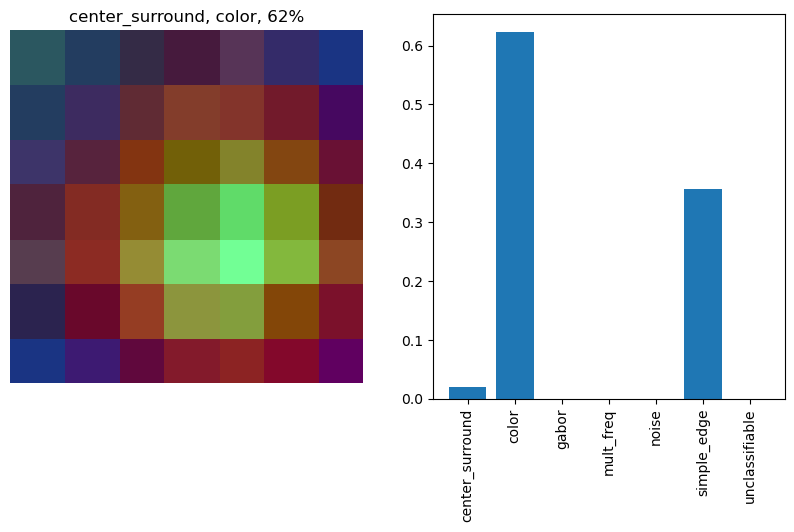

In [206]:
dataset_id = 10
test_img, label = data[dataset_id]

fig,axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(ColorRescale()(test_img.movedim(0,2)))
result = classifier(test_img[None].to(torch.float).to(device))
result_id = result.argmax().item()
axes[0].set_title(id_to_class[label] + ", " + id_to_class[result_id] + ", {:.0%}".format(result[0,result_id]))
axes[0].set_axis_off()
axes[1].bar(data.classes,result[0].detach().cpu())
plt.xticks(rotation=90)
plt.show()

100%|██████████| 4/4 [00:01<00:00,  3.39it/s, Acc.:=0.467]


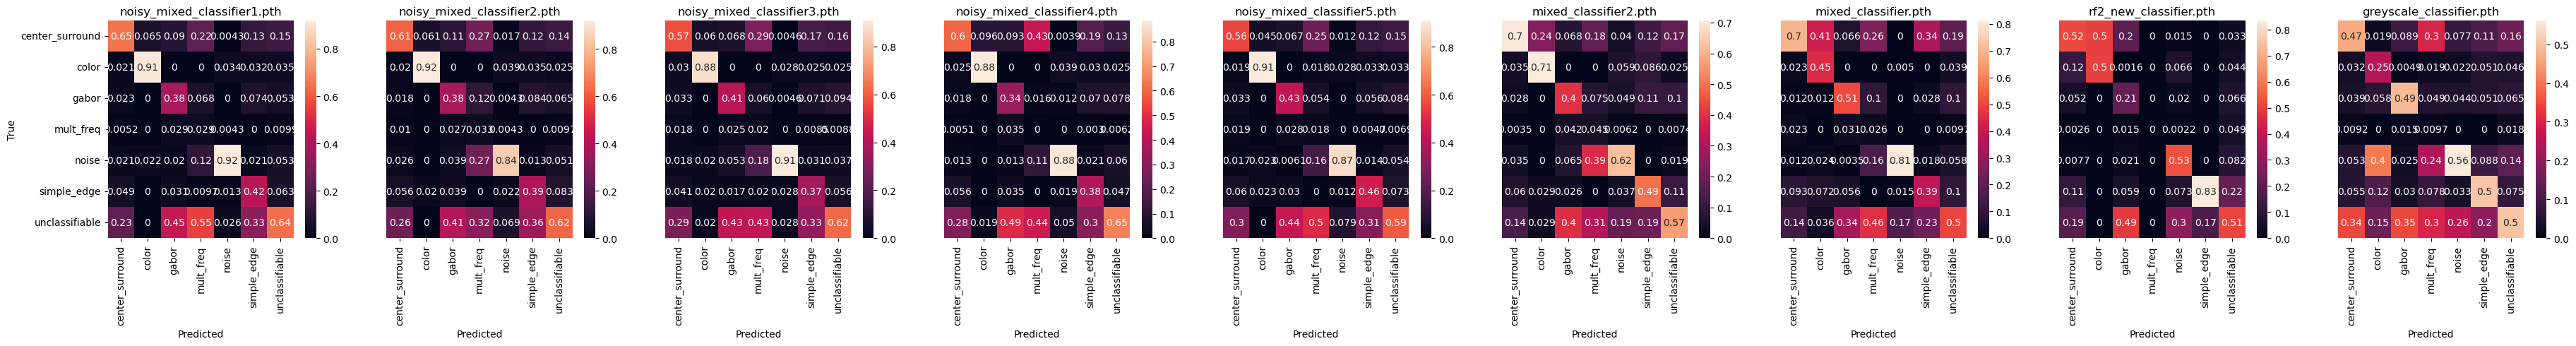

In [207]:
fig, axes = plt.subplots(1,len(classifiers), figsize = (len(classifiers*5), 4))
for i, (ax, classifier) in enumerate(zip(axes,classifiers)):
    acc, outputs, labels = validate(classifier, dataloader, device)
    outputs, labels = np.array(outputs), np.array(labels)
    predicted = np.argmax(outputs, 1)
    conf_matrix = confusion_matrix(labels, predicted, normalize='pred')
    sns.heatmap(conf_matrix, xticklabels = data.classes, yticklabels= data.classes, annot=True, ax = ax)
    if i!=0:
        ax.sharey(axes[0])
        ax.get_yaxis().set_visible(False)
    else:
        ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    ax.set_title(classifier.name)
plt.show()

In [201]:
acc, outputs, labels = ensemble_validate(classifiers, dataloader, device, method="mean")

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  3.32it/s, Acc.:=0.467]


In [202]:
outputs, labels = np.array(outputs), np.array(labels)
predicted = np.argmax(outputs, 1)

In [203]:
print(acc)

0.603881782090869


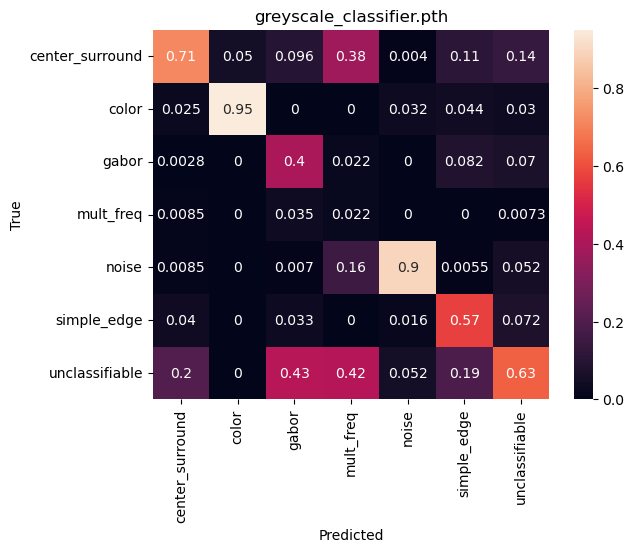

In [204]:
conf_matrix = confusion_matrix(labels, predicted, normalize='pred')
sns.heatmap(conf_matrix, xticklabels = data.classes, yticklabels= data.classes, annot=True)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title(model_name)
plt.show()

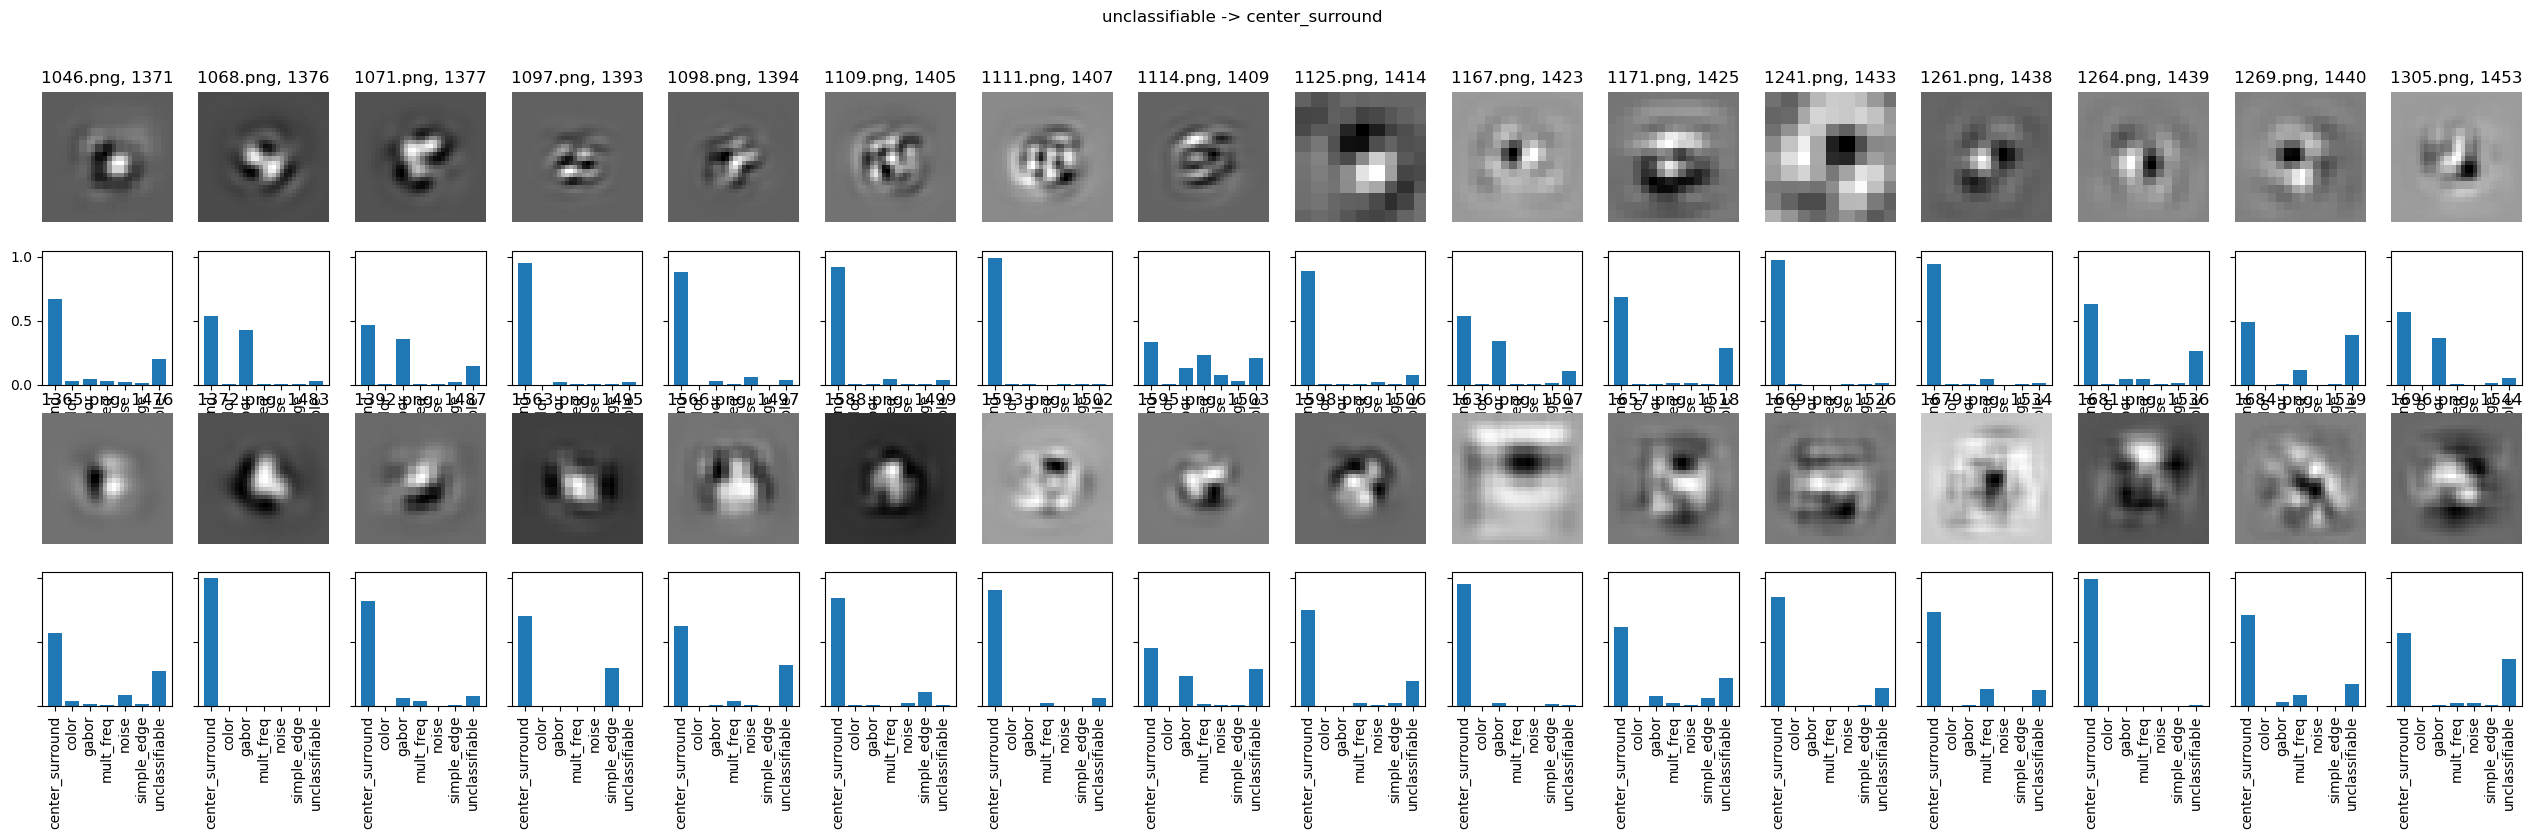

In [214]:
conf_true = 6
conf_pred = 0
d = dataloader.dataset

max_rows=2

indices = np.where((labels==conf_true) * (predicted==conf_pred))[0]
if len(indices) <= 16:
    fig, ax = plt.subplots(2, len(indices), figsize=(4*len(indices)/2,4))
    if(len(indices)==1):
        ax = np.array(ax).reshape(2,1)
else:
    factor = len(indices) // 16
    factor = min(max_rows, factor)
    fig, ax = plt.subplots(2*factor, 16, figsize=(32,4*factor))
    rf_ax = []
    bar_ax = []
    for i in range(factor):
        rf_ax.extend(ax[i*2])
        bar_ax.extend(ax[i*2+1])
    ax = np.array([rf_ax, bar_ax])

fig.suptitle(id_to_class[conf_true] + " -> " + id_to_class[conf_pred])
for ind, ax0, ax1 in zip(indices, ax[0], ax[1]):
    test_img, label = d[ind]
    ax0.imshow(ColorRescale()(transforms.Resize((32,32), interpolation=transforms.InterpolationMode.NEAREST, antialias=None)(transforms.Grayscale(3)(test_img))).movedim(0,2))
    ax0.set_axis_off()
    try:
        filename = os.path.split(d.samples[ind][0])[1]
        ax0.set_title(filename+", "+str(ind))
    except:
        ax0.set_title(ind)

    result = outputs[ind]
    ax1.bar(data.classes,result)
    if ax1 != ax[1,0]:
        ax1.sharey(ax[1,0])
        ax1.tick_params(labelleft=False)
    ax1.set_xticks([i for i in range(len(data.classes))])
    ax1.set_xticklabels(data.classes,rotation=90, ha='center')
plt.show()

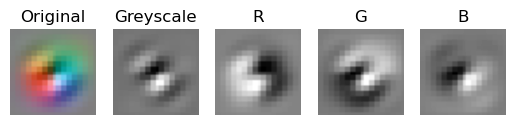

In [212]:
img_no = 1368
img = ColorRescale()(d[img_no][0].movedim(0,2))
fig, axes = plt.subplots(1,5)
axes[0].imshow(img)
axes[0].set_title("Original")
axes[1].imshow(np.average(img, axis=-1), cmap="gray")
axes[1].set_title("Greyscale")
axes[2].imshow(img[...,0], cmap="gray")
axes[2].set_title("R")
axes[3].imshow(img[...,1], cmap="gray")
axes[3].set_title("G")
axes[4].imshow(img[...,2], cmap="gray")
axes[4].set_title("B")

for ax in axes:
    ax.axis('off')

In [171]:
aa

NameError: name 'aa' is not defined

In [ ]:
imgs, labels = next(iter(dataloader))
intermed_rep = classifier.convs(classifier.resize(imgs.to(device))).detach().cpu()

: 

In [ ]:
tsne = TSNE(2).fit_transform(intermed_rep.flatten(start_dim=1))

: 

In [ ]:
scatter = plt.scatter(tsne[labels!=6,0],tsne[labels!=6,1],c=labels[labels!=6])
plt.legend(labels = data.classes, handles=scatter.legend_elements()[0], loc='center left', bbox_to_anchor=(1, 0.5))

: 